In [7]:
import numpy as np
import numpy.linalg as nl
import scipy.linalg as sl
import scipy.special as sps
import scipy.integrate as si
import matplotlib.pyplot as plt

<h3>TDSE Forward Problem</h3>

In [2]:
# size of spatial domain
L = 10.0

# set number of real space grid points for plotting
nx = 1025
# spatial grid for the purposes of plotting
xvec = np.linspace(-L, L, nx)

# the basis functions used in our Fourier representation
# will be from n = -nF to n = nF
nF = 32
# matrix for converting Fourier basis coefficients to real space values
Fnvec = np.arange(-nF, nF + 1) # Fnvec=-nfb,...,0,...,nfb
Fcnvrtmat = np.exp(1j * np.pi * np.outer(Fnvec, xvec) / L) / np.sqrt(2 * L)

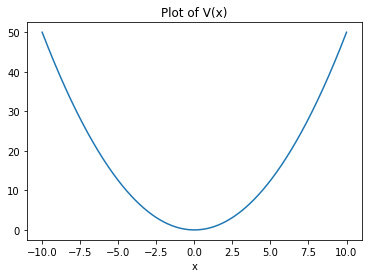

In [3]:
# define potential for generating training data

def v(x):
    # dimensionless quantum harmonic oscillator potential
    return 0.5 * x**2
    # rescaled symmetric double well potential
    # return 0.0025*(x**2 - 25)**2
    # scaled asymmetric double well potential
    # return 0.0003*((x-3)**4 + 10*(x-5)**3)
    # soft coulomb potential
    # return -1 / np.sqrt(x**2 + 0.25)

# compute true potential
vxvec = v(xvec)

# plot true potential
plt.plot(xvec, vxvec)
plt.title('Plot of V(x)')
plt.xlabel('x')
plt.show()

In [4]:
def mkvtoeprowfft(vfn):
    # res adjusts the Fourier transform resolution
    # if res = 1, then nsamples = 2 * nF, which is the
    # Nyquist frequency (most course resolution?)
    res = 100
    nsamples = res * 2 * nF
    x = np.linspace(-L, L, nsamples + 2, endpoint=False)
    Fvvecfft = (np.fft.rfft(vfn(x)) / x.size)[:2 * nF +1]
    vtoeprow = Fvvecfft * (-1)**np.arange(2 * nF +1)
    return vtoeprow

In [5]:
def mkvtoeprowquad(vfn):
    vtoeprow = []
    for thisn in range(2 * nF +1):
        def intgrnd(x):
            return vfn(x) * np.exp(-1j * np.pi * thisn * x / L) / (2 * L)
        def rintgrnd(x):
            return intgrnd(x).real
        def iintgrnd(x):
            return intgrnd(x).imag
        vtoeprow.append(si.quad(rintgrnd, -L, L)[0] + 1j * si.quad(iintgrnd, -L, L)[0])
    return np.array(vtoeprow)

In [6]:
# THIS CELL IS ONLY MEANINGFUL IF v(x) is the SIMPLE HARMONIC OSCILLATOR

def mkvtoeprowharm():
    # for the harmonic oscillator, we can do the integral exactly (thanks, Mathematica!)
    # here is the exact result
    ecfun = lambda i: (L**2 * (2 * i * np.pi * np.cos(i * np.pi) + (-2 + i**2 * np.pi**2) * np.sin(i * np.pi))) / (2.0 * i**3 * np.pi**3)
    exactvrow = np.array(list(map(ecfun, np.arange(1, 2 * nF +1))))
    exactvrow = np.concatenate([np.array([L**2 / 6.0]), exactvrow])
    return exactvrow

# let us check which one is more accurate, FFT or quadrature
print('FFT vtoeprow vs. exact:', nl.norm(mkvtoeprowfft(v) - mkvtoeprowharm()), sep='\n')
print('Quad vtoeprow vs. exact:', nl.norm(mkvtoeprowquad(v) - mkvtoeprowharm()), sep='\n')
# we see that Fvmat is more accurate so we use that!

FFT vtoeprow vs. exact:
6.557417998345006e-06
Quad vtoeprow vs. exact:
6.477425597786634e-14


In [8]:
# construct the kinetic matrix representation of the
# kinetic operator in the Fourier basis
# (this is constant for a given system)
kmat = np.diag(np.arange(-nF, nF + 1)**2 * np.pi**2 / (2 * L**2))

# use mkvtoeprowquad() to create Toeplitz matrix
vrowquad = mkvtoeprowquad(v)
Fvmat = sl.toeplitz(r=vrowquad, c=vrowquad.conj())

# construct the Hamiltonian matrix representation of the
# Hamiltonian operator in the Fourier basis
Fhmat = kmat + Fvmat

# check if the Hamiltonian matrix is Hermitian
print('hmat Hermitian check (should be close to zero):', nl.norm(Fhmat - Fhmat.T.conj()), sep='\n')

# eigen-decomposition of the Hamiltonian matrix
Fspc, Fstts = nl.eigh(Fhmat)

# check if the eigendecomposition diagonalizes the
# Hamiltonian matrix
# if this is close to zero then
# hmat = states @ np.diag(spec) @ np.conj(states).T
print('Check if hmat is diagonalized (should be close to zero):', nl.norm(Fhmat @ Fstts - Fstts @ np.diag(Fspc)), sep='\n')

# check if the eigenstates are unitary
print('Unitary stts check (should be close to zero):', nl.norm(Fstts @ Fstts.T.conj() - np.eye(2 * nF + 1)), sep='\n')

hmat Hermitian check (should be close to zero):
0.0
Check if hmat is diagonalized (should be close to zero):
3.160930230331545e-13
Unitary stts check (should be close to zero):
1.182673699250653e-14


[0.5 1.5 2.5 3.5 4.5 5.5]


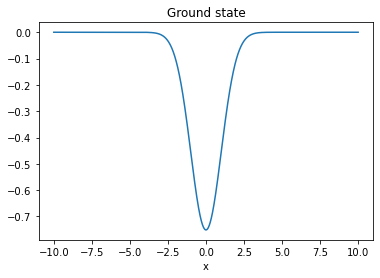

Quick check of normalization (should be close to 1):
1.0000000000000002
Check of normalization (should be close to 1):
1.0000000000000002


In [17]:
# find indices that sort eigenvalues
ordering = np.argsort(Fspc)

# print the first few eigenvalues
print(Fspc[ordering[:6]])

# pick out and plot ground state
groundstate = ordering[0]
wavefn = Fstts[:,groundstate] @ Fcnvrtmat
plt.plot(xvec, np.real(wavefn))
plt.title('Ground state')
plt.xlabel('x')
plt.show()

# quick and dirty check of normalization
print('Quick check of normalization (should be close to 1):', np.sum(np.abs(wavefn)**2 * (xvec[1]-xvec[0])), sep='\n')

# this should be a more accurate check of the ground state
# wave functions' normalization
print('Check of normalization (should be close to 1):', si.trapezoid(np.abs(wavefn)**2, xvec), sep='\n')

[ 2.50000000e+01  4.73695157e-15  2.50000000e+01  3.55271368e-15
 -9.47390314e-15  2.13162821e-14 -4.73695157e-15  1.42108547e-14
 -1.06581410e-14  1.65793305e-14 -3.43428989e-14  2.19084010e-14]


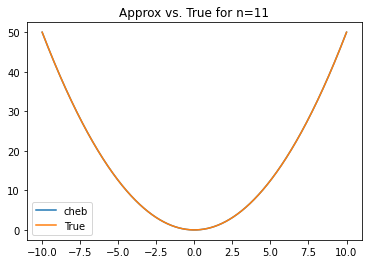

L-infinity Norm:
1.4921397450962104e-13


In [19]:
# let us represent V(x) using Chebyshev polynomial
# for the simple harmonic potential this should be
# exact because V(x) **is** a polynomial

nc = 11

def theta(k):
    return (k - 0.5) * np.pi / (nc + 1)

def g(k):
    # cos(\theta) ranges from [-1, 1] which is the domain
    # of the Chebyshev interpolation function so we need to
    # modify v()'s so when it is given x \in [-1, 1], it
    # actually spans the domain [-L, L]
    # to do that, we multiply by np.cos(theta(k)) by L
    return v(L * np.cos(theta(k)))

kvec = np.arange(1, nc + 2)
cnvec = np.arange(0, nc + 1)

cweights = np.ones(nc + 1)
cweights[0] = 0.5

# compute Chebyshev coefficients
cvec = 2 / (nc + 1) * np.sum(g(kvec) * np.cos(cnvec[..., np.newaxis] * theta(kvec)), axis=1)
cvec = cweights * cvec
print(cvec)

ccnvrtmat = sps.eval_chebyt(np.expand_dims(cnvec, 0), np.expand_dims(xvec / L, 1))

vrec = ccnvrtmat @ cvec

# plot reconstruction vs truth
plt.plot(xvec, vrec, label='cheb')
plt.plot(xvec, vxvec, label='True')
plt.title(f'Approx vs. True for n={nc}')
plt.legend()
plt.show()

# Linfty norm error
print('L-infinity Norm:', np.max(np.abs(v(xvec) - vrec)), sep='\n')

In [24]:
# now form the entries of vmat from the Chebyshev
# representation by quadrature method

# this function returns the chebyshev approximation of
# the potential at some spatial point x
def vchebaprx(x):
    # don't for get the interval of x is [-L, L] but for
    # the chebyshev representation it needs to be [-1, 1]
    return sps.eval_chebyt(np.expand_dims(cnvec, 0), x / L) @ cvec

vchebrowquad = np.zeros(2 * nF + 1, dtype=np.complex128)
for thisn in range(2 * nF + 1):
    def intgrnd(x):
        return vchebaprx(x) * np.exp(-1j * np.pi * thisn * x / L) / (2 * L)
    def rintgrnd(x):
        return intgrnd(x).real
    def iintgrnd(x):
        return intgrnd(x).imag
    vchebrowquad[thisn] = si.quad(rintgrnd, -L, L)[0] + 1j * si.quad(iintgrnd, -L, L)[0]

In [25]:
# check how much vchebrowquad differ from vrowquad
# made with mkvtoeprowquad() (i.e. potential to Fourier
# representation rather than potential to chebyshev rep
# to Fourier rep)
print('L2 Norm Error:', nl.norm(vrowquad - vchebrowquad))
print('L-infinity Error:', np.max(np.abs(vrowquad - vchebrowquad)))


L2 Norm Error: 3.323854363582271e-14
L-infinity Error: 1.2101348630776924e-14


In [31]:
# Let's compare the Hamiltonian matrix and its
# eigendecomposition for the Chebyshev representation
# of the potential to the Fourier representation of
# of the potential
cvmat = sl.toeplitz(r=vchebrowquad, c=vchebrowquad.conj())

# construct the Hamiltonian matrix representation of the
# Hamiltonian operator in the Fourier basis
chmat = kmat + cvmat

# check if the Hamiltonian matrix is Hermitian
print('hmat Hermitian check (should be close to zero):', nl.norm(chmat - chmat.T.conj()), sep='\n')

# eigendecomposition of the Hamiltonian matrix
cspc, cstts = nl.eigh(chmat)

# check if the eigendecomposition diagonalizes the
# Hamiltonian matrix
# if this is close to zero then
# hmat = states @ np.diag(spec) @ np.conj(states).T
print('Check if hmat is diagonalized (should be close to zero):', nl.norm(chmat @ cstts - cstts @ np.diag(cspc)), sep='\n')

# check if the eigenstates are unitary
print('Unitary stts check (should be close to zero):', nl.norm(cstts @ cstts.T.conj() - np.eye(2 * nF + 1)), sep='\n')

hmat Hermitian check (should be close to zero):
0.0
Check if hmat is diagonalized (should be close to zero):
4.2231608591843004e-13
Unitary stts check (should be close to zero):
1.2631304321995936e-14


(257,)
(257, 1025)


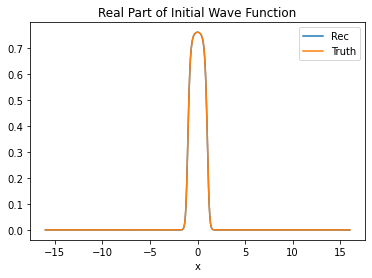

Rel Norm Diff: 5.020489938219892e-05


In [41]:
# define initial state and transform to Fourier basis

def psi0(x):
    # rounded box function
    # return 1.0 + np.tanh((1 - x**2)/0.5)
    # HSB's manually normalized rounded box function
    # return (1.0 + np.tanh((1 - x**2)/0.5)) / 2.58046
    # triangular pulse
    # return np.piecewise(x, [x < -1, (x >= -1) & (x <= 1), x > 1], [0, lambda x: (1 - np.abs(x)), 0])
    # parabolic pulse
    # return np.piecewise(x, [x < -1, (x >= -1) & (x <= 1), x > 1], [0, lambda x: (1 - x**2), 0])
    # hyperbolic secant squared
    # return (np.cosh(x))**(-2)
    # Laplace
    # return np.exp(-np.abs(x))
    return np.exp(-x**2) * (2.0 / np.pi)**0.25

# function for normalizing psi0
# uncomment when not using Harish's psi0
def mknormpsifn(psifn):
    # compute psi normalization term,
    # this is a constant given some psi
    psiprobintegrand = lambda x: np.abs(psifn(x))**2
    normterm = np.sqrt(si.quad(psiprobintegrand, a=-l, b=l)[0])

    # define function for computing normalized psi
    # via scipy.integrate methods
    def normpsifn(x):
        return psifn(x)/normterm

    return normpsifn

# normpsi0fn = mknormpsifn(psi0)  # when not using Harish's psi0
normpsi0fn = psi0  # when using Harish's psi0
# vector of the normalized psi0 function sampled on the
# real space grid for plotting
normpsi0vec = normpsi0fn(xvec)

# compute the Fourier basis representation of the
# normalized psi0 function using a scipy.integrate method
normpsi0integrand = lambda x: np.exp(-1j * np.pi * Fnvec * x / L) / np.sqrt(2 * L) * normpsi0fn(x)
normpsi0quadrtn = si.quad_vec(normpsi0integrand, -L, L)[0]
print(normpsi0quadrtn.shape)
print(Fcnvrtmat.shape)
Fnormpsi0vecrec = normpsi0quadrtn @ Fcnvrtmat

# plot the real part of the normalized psi0
plt.plot(xvec, Fnormpsi0vecrec.real, label="Rec")
plt.plot(xvec, normpsi0vec.real, label="Truth")
plt.title('Real Part of Initial Wave Function')
plt.xlabel('x')
plt.legend()
plt.show()

print('Rel Norm Diff:', nl.norm(normpsi0vec - Fnormpsi0vecrec) / nl.norm(normpsi0vec))

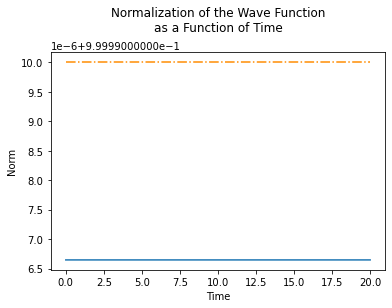

Average Norm of Trajectory (should be close to 1):
0.9999966470021467


In [64]:
# solve the forward problem and generate amat
# set the time step and compute the propagator matrix
# note that we are reusing the spectrum and states from
# the eigendecomposition of Hamiltonian matrix computed above

# set the size of a time step
dt = 0.01

# make the propagator matrix
Fpropa = Fstts @ np.diag(np.exp(-1j * Fspc * dt)) @ Fstts.conj().T

# set the number of time steps to take starting from
# the initial state (a single trajectory should be
# nts + 1 states, this includes the initial state)
nts = 2000

# propagate the system starting from the initial "a" state
Famat = np.zeros((nts + 1, 2 * nF + 1), dtype=np.complex128)
Famat[0,:] = normpsi0quadrtn.copy()
for i in range(nts):
    Famat[i + 1,:] = Fpropa @ Famat[i,:]

# check if the wave function of each time step
# is normalized to 1
# this should produce a graph with a line that is almost
# completely horizontal at 1
psimatnormvec = si.trapezoid(np.abs(Famat @ Fcnvrtmat) ** 2, xvec, axis=1)
plt.plot(np.arange(nts + 1) * dt, psimatnormvec)
plt.hlines(1 , 0, nts * dt, linestyles='-.', colors='darkorange')
plt.title('Normalization of the Wave Function\nas a Function of Time\n')
plt.xlabel('Time')
plt.ylabel('Norm')
plt.show()

# norm difference of wave function normalization check,
# this should be close to 1
print('Average Norm of Trajectory (should be close to 1):', psimatnormvec.sum() / (nts + 1), sep='\n')

In [51]:
Cvmat = mkvmatfft(chebtoxvec)
# Cvmat = mkvmatquad(chebtox)
print(Cvmat.shape)

# construct the Hamiltonian matrix representation of the
# Hamiltonian operator in the Fourier basis
Chmat = kmat + Cvmat

# check if the Hamiltonian matrix is Hermitian
print('hmat Hermitian check (should be close to zero):', nl.norm(Chmat - Chmat.T.conj()), sep='\n')

# eigen-decomposition of the Hamiltonian matrix
Cspc, Cstts = nl.eigh(Chmat)

# check if the eigendecomposition diagonalizes the
# Hamiltonian matrix
# if this is close to zero then
# hmat = states @ np.diag(spec) @ np.conj(states).T
print('Check if hmat is diagonalized (should be close to zero):', nl.norm(Chmat @ Cstts - Cstts @ np.diag(Cspc)), sep='\n')

# check if the eigenstates are unitary
print('Unitary stts check (should be close to zero):', nl.norm(Cstts @ Cstts.conj().T - np.eye(2 * nF + 1)), sep='\n')

(257, 257)
hmat Hermitian check (should be close to zero):
0.0
Check if hmat is diagonalized (should be close to zero):
4.7960987213668505e-12
Unitary stts check (should be close to zero):
4.165733141838007e-14


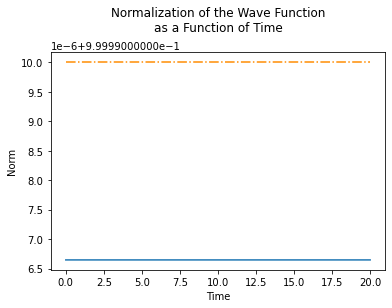

Average Norm of Trajectory (should be close to 1):
0.999996647003928


In [52]:
# make the propagator matrix
Cpropa = Cstts @ np.diag(np.exp(-1j * Cspc * dt)) @ Cstts.conj().T

# propagate the system starting from the initial "a" state
Camat = np.zeros((nts + 1, 2 * nF + 1), dtype=np.complex128)
Camat[0,:] = normpsi0quadrtn.copy()
for i in range(nts):
    Camat[i + 1,:] = Cpropa @ Camat[i,:]

# check if the wave function of each time step
# is normalized to 1
# this should produce a graph with a line that is almost
# completely horizontal at 1
psimatnormvec = si.trapezoid(np.abs(Camat @ Fcnvrtmat) ** 2, xvec, axis=1)
plt.plot(np.arange(nts + 1) * dt, psimatnormvec)
plt.hlines(1 , 0, nts * dt, linestyles='-.', colors='darkorange')
plt.title('Normalization of the Wave Function\nas a Function of Time\n')
plt.xlabel('Time')
plt.ylabel('Norm')
plt.show()

# norm difference of wave function normalization check,
# this should be close to 1
print('Average Norm of Trajectory (should be close to 1):', psimatnormvec.sum() / (nts + 1), sep='\n')

Vec Norm Diff of Famat & Camat (should be close to 0):
0.5524896931830702


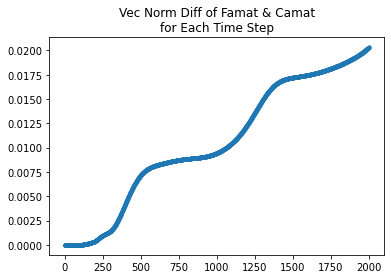

In [53]:
print('Vec Norm Diff of Famat & Camat (should be close to 0):', nl.norm(Famat - Camat), sep='\n')

plt.plot(nl.norm(Famat - Camat, axis=1), '.')
plt.title('Vec Norm Diff of Famat & Camat\nfor Each Time Step')
plt.show()